@WSS: Winter-Spring School 2021

12 June 2021

Jupyter notebook Author: Naresh Adhikari

### Let's import relevant packages.

In [134]:
#import bilby
# !pip install bilby 
# !conda install -c conda-forge bilby
import numpy as np
import matplotlib.pyplot as plt

### Define a model.

In [135]:
def modelA(time, omega):
    return np.sin(omega*time)

### Simulate data.

In [136]:
sigma = 0.1
omega_true = 1.2
time = np.linspace(0,12,100)
ydet = modelA(time, omega = omega_true)
yobs = ydet + np.random.normal(0,sigma,len(time)) # Observed data = SIGNAL + GAUSSIAN NOISE


### Plot data.

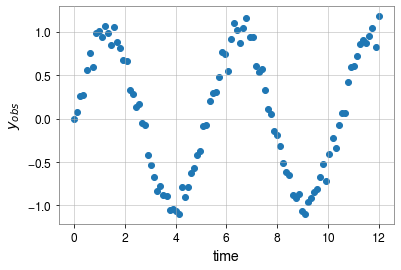

In [137]:
plt.plot(time, yobs, "o")
plt.ylabel("$y_{obs}$"); plt.xlabel("time")
plt.show()

$ln\mathcal{L} = -\frac{1}{2} \sum (\frac {(y - <y>)^2}{\sigma ^2}) + log (2 \pi \sigma^2 )$ 

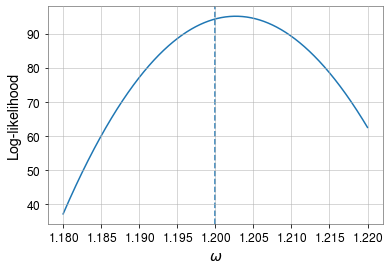

In [138]:
def ln_likelihood(yobs, time, omega, sigma = 0.1):
    yA = modelA(time, omega)
    ln_likes = -0.5 * ((yobs-yA)**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return np.sum(ln_likes)

omega_grid = np.linspace(omega_true - 2e-2, omega_true + 2e-2 , 1000)
ln_likelihood_grid = []
for omega in omega_grid:
    ln_likelihood_grid.append(ln_likelihood(yobs, time, omega))
    
plt.plot(omega_grid, ln_likelihood_grid)
plt.axvline(omega_true, ls = '--')
plt.xlabel("$\omega$");plt.ylabel("Log-likelihood")
plt.show()

    

In [139]:
#ln_likelihood(yobs = yobs,time = time,omega = 1.20, sigma = 0.5)

### Maximum likelihood

In [140]:
#help(np.argmax)

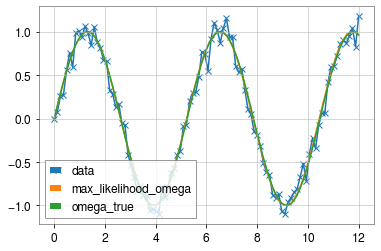

In [141]:
max_likelihood_omega = omega_grid[np.argmax(ln_likelihood_grid)]
plt.plot(time, yobs, '-x', label = 'data')
plt.plot(time, modelA(time, max_likelihood_omega), label = 'max_likelihood_omega')
plt.plot(time, modelA(time, omega_true), label = 'omega_true')
plt.legend(loc = 'lower left')
plt.show()

In [142]:
max_likelihood_omega

1.2026626626626626

#### What is missing in the above graph ? 
Now let's look at the note.

### Normalised posterior density function (pdf)
#### Let's plot the posterior (equal to the likelihood in this case) taking an exponent.

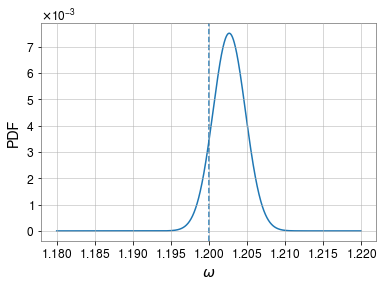

In [143]:
pdf_unnormalized = np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid))
pdf_normalized = pdf_unnormalized / np.sum(pdf_unnormalized)
plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--') # vertical line
plt.xlabel("$\omega$")
plt.ylabel("PDF")
plt.show()


In [144]:
omega_grid

array([1.18      , 1.18004004, 1.18008008, ..., 1.21991992,
       1.21995996, 1.22      ])

In [145]:
pdf_normalized

array([5.01854023e-28, 6.16958352e-28, 7.58178577e-28, ...,
       7.00710521e-17, 6.03732862e-17, 5.20001560e-17])

### Why is the peak not consistent with the true value?
- Cleary the median of this distribution does not agree with the true value.
- The noise in the observed data means that we have uncertainty !
- How can be quantify this?
- Bayesian answer is the credible interval.
- We should always report inferences as $\omega$ has a median of XX and lies between YY and ZZ with 95\% probability.
- How do we figure out these numbers?


## Cumulative distribution


$CDF(\omega) = \int_{-\infty}^{\omega}P(\omega'|data) d\omega'$

In [146]:
#help(np.cumsum)


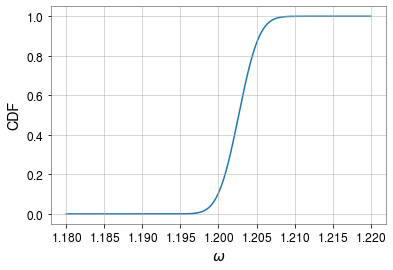

In [147]:
cdf = np.cumsum(pdf_normalized)
plt.plot(omega_grid, cdf)
plt.xlabel("$\omega$")
plt.ylabel("CDF")
plt.show()

In [148]:
cdf

array([5.01854023e-28, 1.11881238e-27, 1.87699095e-27, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

- The median is the point where the CDF passes through 0.5
- We can find the 90% confidence interval by finding the 0.05 and 0.95 numbers (such that the interval contains 90% of the probability)


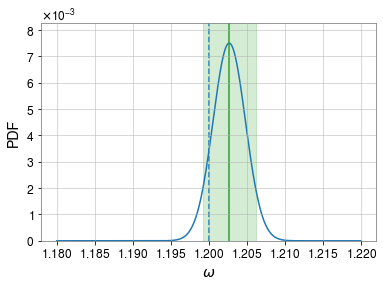

In [149]:
median = omega_grid[np.argmin(np.abs(cdf - 0.5))]
low_bound = omega_grid[np.argmin(np.abs(cdf - 0.05))]
upper_bound = omega_grid[np.argmin(np.abs(cdf - 0.95))]

plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.fill_between([low_bound, upper_bound], 0, 2 * np.max(pdf_normalized), color='C2', alpha=0.2)
plt.axvline(median, color='C2')
plt.ylim(0, 1.1 * np.max(pdf_normalized)); plt.xlabel("$\omega$"); plt.ylabel("PDF")
plt.show()

## Let's complicate things.
- In low-dimensions, evaluating a grid of points isn't too crazy
- In high-dimensionl problems, the number of grid points scales with the number of dimensions!
- Here we turn to stochastic sampling algorithms

## Building a peak-finding algorithm.


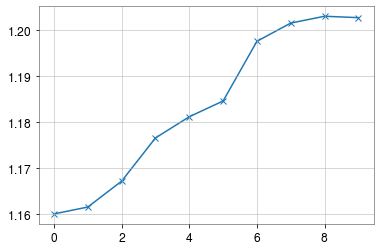

In [150]:
omega_values = [1.16] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1]:
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
        
plt.plot(omega_values, '-x')
plt.show()

In [151]:
omega_values[0]

1.16

- Good at finding the peak of a unimodel likelihood to arbitrary precision
- Bad if things are multimodal
- Doesn't tell us anything about the "structure"

## Very basic Metropolis-Hastings sampler
### Markov-Chain Monte-Carlo samplers use "randomness" to sample from the posterior distribution



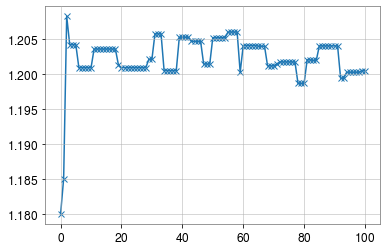

In [152]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

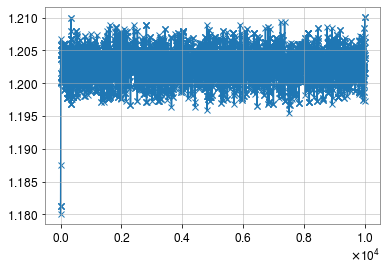

In [153]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(10000):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

### Histogram the samples

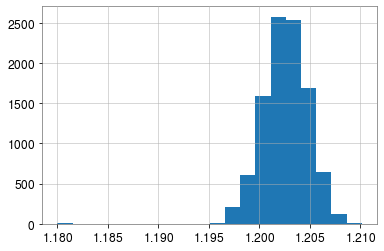

In [156]:

_ = plt.hist(omega_values, bins=20)

### Sampling takeaways
- Stochastic samplers are all about drawing "samples" from the posterior distribution

- Simple MCMC methods need tuning

- Advanced MCMC methods have fewer tuning parameters

- Parallel tempering is required to deal with multi-model distributions
- Can calculate evidences (but not advised).
- Nested Sampling is better than MCMC

- Calculated evidences by design
- Deals well with multimodal distributions

# References:

- GregoryAshton: Inference- Data analysis hands on training.